Table of Contents:

1.   Installation of Necessary Packages

2.   Reviews Preprocessing and Cleaning

3.   Story Generation and Visualization from reviews

4.   Extracting Features from Cleaned reviews

5.   Model Building: Sentiment Analysis






### INSTALLATION OF PACKAGES  
1. VISULAIZATION LIBRARIES FOR THE ANALYSIS
- Word cloud
- Text Blob
- Plotly

In [2]:
# %pip install wordcloud

In [3]:
# %pip install -qq -U textblob

In [4]:
# %pip install -qq cufflinks

INSTALL AND APPLY ALGORITHMS LATER IN THE END
- XGBOOST
- LIGHTGBM
- CATBOOST

In [5]:
# import basic libraries
import pandas as pd 
import numpy as np 

# import progress bar module
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


# import visualization tools
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

# import text preprocessing tools
import nltk
import re
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# import sklearn preprocessing packages and pipelines
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

# import sklearn model_selection modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

# import sklearn models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# import sklearn metrics libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import other libraries
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter

# initiate random_seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# initialize our fig size
rcParams['figure.figsize'] = 12, 10

LOAD THE REVIEW CSV FILES 

In [6]:
# load and check the first five rows of the csv
review_df = pd.read_csv('./Data/reviews.csv')
review_df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,https://play-lh.googleusercontent.com/a-/AFdZu...,Useless and frustrated app in terms of custome...,1,0,2.4.47,2022-07-21 09:28:55,NaN,NaN,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,https://play-lh.googleusercontent.com/a-/AFdZu...,"Scammers, the lot of them. Don't download this...",1,17,2.4.45,2022-06-29 08:59:48,"Hello, we are so sorry for the inconvenience. ...",2022-07-01 16:31:33,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,https://play-lh.googleusercontent.com/a/AItbvm...,"My experience hasn't been good,the app keeps l...",1,3,2.4.45,2022-07-20 18:57:04,"Hi Victor, this must have been a frustrating e...",2022-07-21 04:22:29,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,https://play-lh.googleusercontent.com/a/AItbvm...,Very annoying app ever. I signed up account an...,1,8,2.4.44,2022-06-04 22:29:25,"Hello, We apologise for the inconvenience caus...",2022-06-09 06:00:42,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,https://play-lh.googleusercontent.com/a-/AFdZu...,I thought the experience would be an awesome o...,1,1,2.4.44,2022-06-03 20:53:11,"Hi Prince, we are so sorry about your experien...",2022-06-09 04:30:57,most_relevant,com.flutterwave.flybarter


In [7]:
print('The review dataset has {} features and {} observations'.format(review_df.shape[1], review_df.shape[0]))

The review dataset has 12 features and 21932 observations


<h3>Dataset Details</h3>


<p>Description of columns in the file: </p>

<li>reviewID - ID of the reviewer, e.g. 52b105b4-77e0-4018-87dc-e66c9625790d </li>
<li>userName - ID of the product, e.g.Prince Simeon.A </li>
<li>userImage - image link of the reveiwer</li>
<li>content - sentiment/text of the reviewer</li>
<li>score - the rating score from the reviewer (1-5)</li>
<li>thumbsUpCount - The number of individuals that like or share the same idea with the review texts</li>
<li>reviewCreatedVersion - The version of the review </li>
<li>at - datetime of the review (str)</li>
<li>replyContent - text/reply of the developer </li>
<li>repliedAt - datetime the sentiment is replied to  (str)</li>
<li>reviewText - text of the review</li>
<li>sortOrder - the order of sorting the review</li>
<li>appId - id of the app</li>

In [8]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21932 entries, 0 to 21931
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              21932 non-null  object
 1   userName              21932 non-null  object
 2   userImage             21932 non-null  object
 3   content               21932 non-null  object
 4   score                 21932 non-null  int64 
 5   thumbsUpCount         21932 non-null  int64 
 6   reviewCreatedVersion  19025 non-null  object
 7   at                    21932 non-null  object
 8   replyContent          13429 non-null  object
 9   repliedAt             13429 non-null  object
 10  sortOrder             21932 non-null  object
 11  appId                 21932 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.0+ MB


### Data Preprocessing and cleaning

In [9]:
# make a copy of the review_df for preprocessing
# change the columns text and replace the space with dash
preprocess_review = review_df.copy()
columns = [col.replace(' ', '_').lower() for col in preprocess_review.columns]
preprocess_review.columns = columns
preprocess_review.head()

,reviewid,username,userimage,content,score,thumbsupcount,reviewcreatedversion,at,replycontent,repliedat,sortorder,appid
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,https://play-lh.googleusercontent.com/a-/AFdZu...,Useless and frustrated app in terms of custome...,1,0,2.4.47,2022-07-21 09:28:55,NaN,NaN,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,https://play-lh.googleusercontent.com/a-/AFdZu...,"Scammers, the lot of them. Don't download this...",1,17,2.4.45,2022-06-29 08:59:48,"Hello, we are so sorry for the inconvenience. ...",2022-07-01 16:31:33,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,https://play-lh.googleusercontent.com/a/AItbvm...,"My experience hasn't been good,the app keeps l...",1,3,2.4.45,2022-07-20 18:57:04,"Hi Victor, this must have been a frustrating e...",2022-07-21 04:22:29,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,https://play-lh.googleusercontent.com/a/AItbvm...,Very annoying app ever. I signed up account an...,1,8,2.4.44,2022-06-04 22:29:25,"Hello, We apologise for the inconvenience caus...",2022-06-09 06:00:42,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,https://play-lh.googleusercontent.com/a-/AFdZu...,I thought the experience would be an awesome o...,1,1,2.4.44,2022-06-03 20:53:11,"Hi Prince, we are so sorry about your experien...",2022-06-09 04:30:57,most_relevant,com.flutterwave.flybarter


In [10]:
# check the null value
preprocess_review.isnull().sum()

reviewid                   0
username                   0
userimage                  0
content                    0
score                      0
thumbsupcount              0
reviewcreatedversion    2907
at                         0
replycontent            8503
repliedat               8503
sortorder                  0
appid                      0
dtype: int64

In [11]:
# Get the null_value columns 
null_columns = preprocess_review.columns[preprocess_review.isna().any()].to_list()
null_columns

['reviewcreatedversion', 'replycontent', 'repliedat']

In [12]:
#drop the null value columns as it is not really useful in our analysis and also classify the sentiment
# drop the user image, username
preprocess_review.drop(null_columns, axis = 1, inplace=True)
preprocess_review.drop(['userimage', 'username'], axis = 1, inplace=True)
preprocess_review.head()

,reviewid,content,score,thumbsupcount,at,sortorder,appid
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter


In [13]:
# rename columns
preprocess_review.rename({'content':'reviews', 'at':'datetime'}, axis =1, inplace=True)

In [14]:
preprocess_review.head()

,reviewid,reviews,score,thumbsupcount,datetime,sortorder,appid
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter


In [15]:
# check the distribution of each rating score
rating_count = preprocess_review.score.value_counts().sort_index()
rating_count

1    4000
2    3506
3    6544
4    3882
5    4000
Name: score, dtype: int64

<AxesSubplot:title={'center':'The distribution of rating scores of the reviews'}, xlabel='Rating', ylabel='Frequency'>

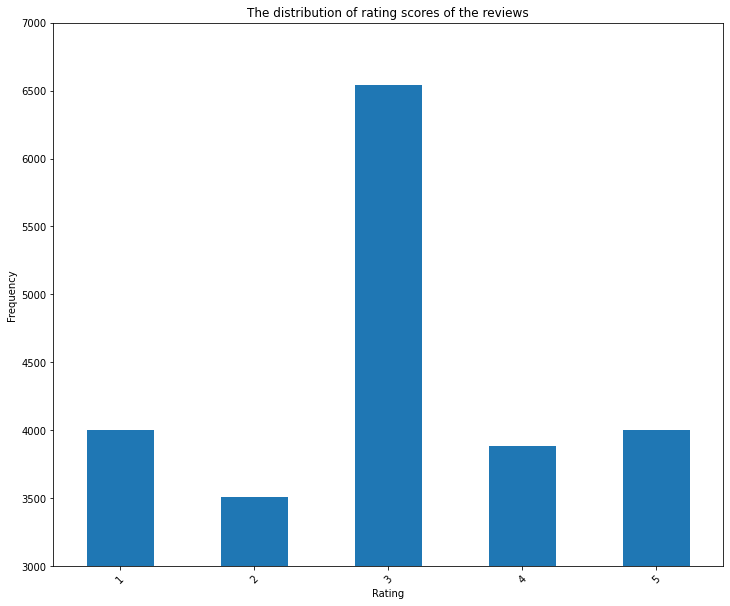

In [16]:
# create a bar plot of the ratings distribution
rating_count.plot(
kind = 'bar',
rot = 45,
ylim = (3000, 7000),
title = 'The distribution of rating scores of the reviews',
ylabel = 'Frequency',
xlabel= 'Rating'
)

### Create sentiment column
<p>This is an important preprocessing phase, we will create column (sentiment of review) based on the rating score. If the score is greater than 3, we take it as positive, less than 3 taken as negative, equal to 3, we take as Neutral sentiment.</p>

In [17]:
# function to create sentiment
def sentiment(row):
    
    '''This function returns sentiment value based on the scores from the user'''
    
    if row['score'] == 3.0:
        val = 'Neutral'
    elif row['score'] == 1.0 or row['score'] == 2.0:
        val = 'Negative'
    elif row['score'] == 4.0 or row['score'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [18]:
# create the sentiment column
preprocess_review['sentiment'] = preprocess_review.apply(sentiment, axis = 1)
preprocess_review.head()

,reviewid,reviews,score,thumbsupcount,datetime,sortorder,appid,sentiment
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter,Negative
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter,Negative
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter,Negative
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter,Negative
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter,Negative


In [19]:
# check the distribution of the sentiment
preprocess_review.sentiment.value_counts()

Positive    7882
Negative    7506
Neutral     6544
Name: sentiment, dtype: int64

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of Sentiment')]

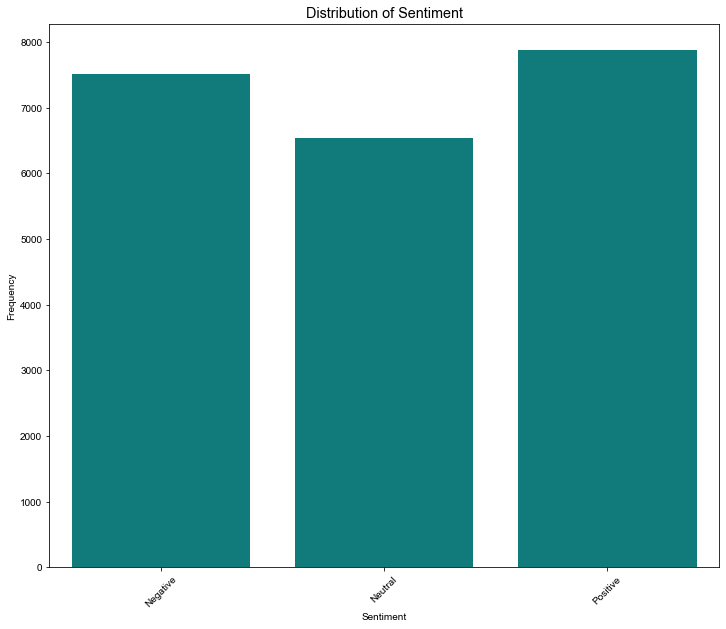

<Figure size 360x360 with 0 Axes>

In [20]:
sentiment_plot = sns.countplot(preprocess_review['sentiment'], color='darkcyan')
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.xticks(rotation = 45)
plt.figure(figsize=(5,5))
sentiment_plot.set(xlabel = 'Sentiment', ylabel = 'Frequency', title='Distribution of Sentiment' )

LETS SEE HOW REVIEWS ARE BEEN LIKED WITH THEIR SENTIMENT

In [21]:
# this thumbsupcount shows how relevant the text to correaponding reviewers
preprocess_review.thumbsupcount.value_counts()

0       16333
1        1930
2         711
3         426
4         267
        ...  
358         1
1034        1
688         1
571         1
1475        1
Name: thumbsupcount, Length: 279, dtype: int64

In [22]:
# grouping how the each ratings with text has been hepful to other fellow
helpful_review = preprocess_review.groupby('score')['thumbsupcount'].sum()
helpful_review

score
1    26751
2    19837
3    37131
4    39102
5    26090
Name: thumbsupcount, dtype: int64

<AxesSubplot:title={'center':'Distribution of helpful reviews based on sentiments of each reviews'}, xlabel='Rating score', ylabel='Frequency'>

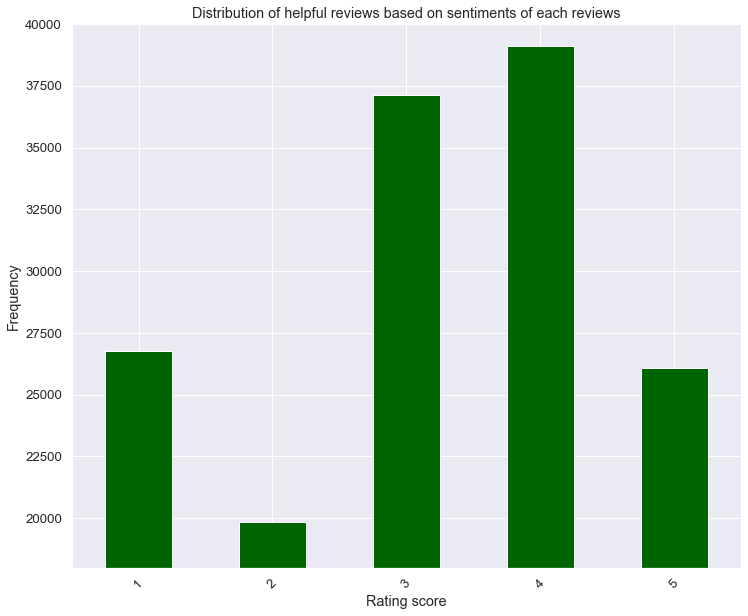

In [23]:
# create a bar plot of the helpful reviews distribution
helpful_review.plot(
kind = 'bar',
color = 'darkgreen',
rot = 45,
ylim = (18000, 40000),
title = 'Distribution of helpful reviews based on sentiments of each reviews',
ylabel = 'Frequency',
xlabel= 'Rating score'
)

#### Let's check if there is any relationship between the sentiment and datetime

In [24]:
preprocess_review['datetime'] = pd.to_datetime(preprocess_review['datetime'])
preprocess_review['year'] = preprocess_review.datetime.dt.year
preprocess_review['month'] = preprocess_review.datetime.dt.month_name()
preprocess_review['day'] = preprocess_review.datetime.dt.day
preprocess_review.head()

,reviewid,reviews,score,thumbsupcount,datetime,sortorder,appid,sentiment,year,month,day
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter,Negative,2022,July,21
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter,Negative,2022,June,29
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter,Negative,2022,July,20
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter,Negative,2022,June,4
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter,Negative,2022,June,3


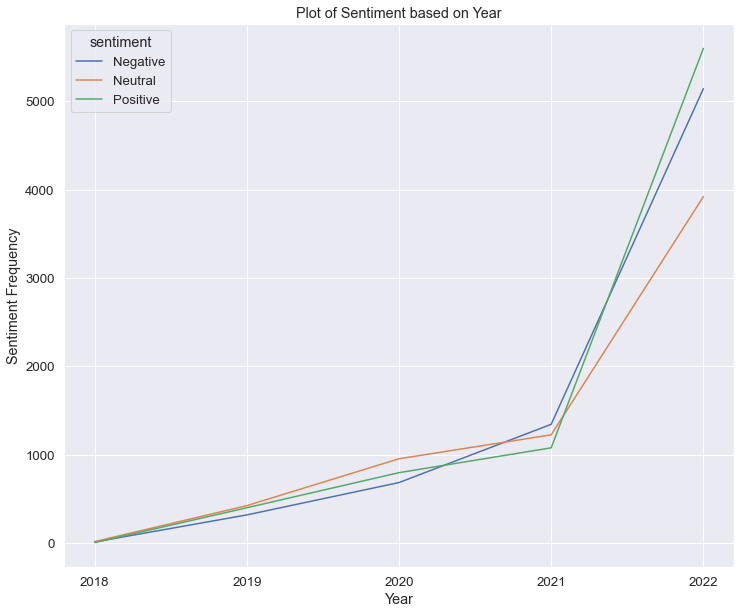

In [25]:
# Plot how Year Vs sentiment
xlim = preprocess_review.year.value_counts(ascending=True).index.to_list()
preprocess_review.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Plot of Sentiment based on Year')
plt.xlabel('Year')
plt.xticks(xlim)
plt.ylabel('Sentiment Frequency')
plt.show()


In [26]:
month_sort = [x.split()[1] for x in preprocess_review.datetime.dt.strftime('%m %B').value_counts().sort_index().index]
month_sentiment  = preprocess_review.groupby(['month','sentiment'])['sentiment'].count().unstack().reindex(month_sort)
month_sentiment.index = [col[:3] for col in month_sentiment.index]
month_sentiment

sentiment,Negative,Neutral,Positive
Jan,307,262,257
Feb,358,391,411
Mar,562,500,518
Apr,660,618,581
May,733,614,745
Jun,1485,1541,1263
Jul,2143,1358,3009
Aug,226,245,166
Sep,246,311,276
Oct,258,226,206


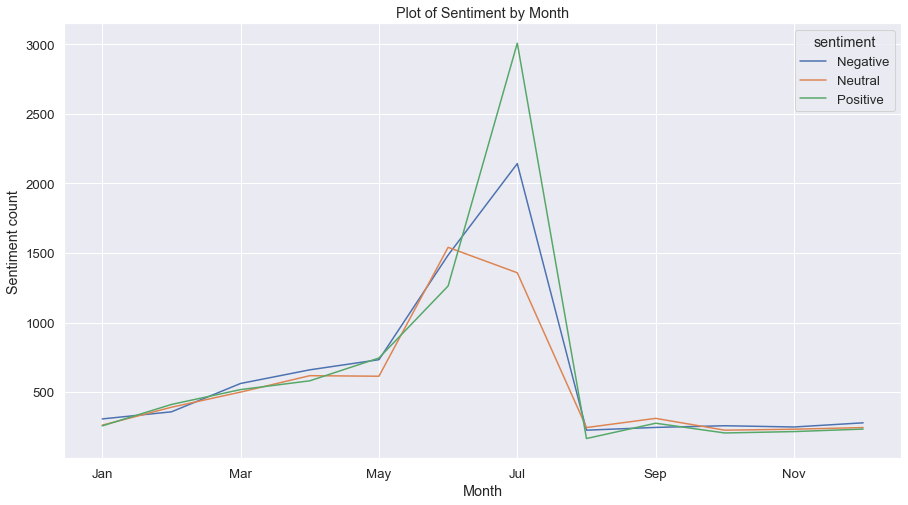

In [27]:
# let check for relationship betwenn month and 
month_sentiment.plot(legend= True, figsize= (15,8))
plt.title('Plot of Sentiment by Month')
plt.xlabel('Month')
plt.ylabel('Sentiment count')
plt.show()

<AxesSubplot:xlabel='day'>

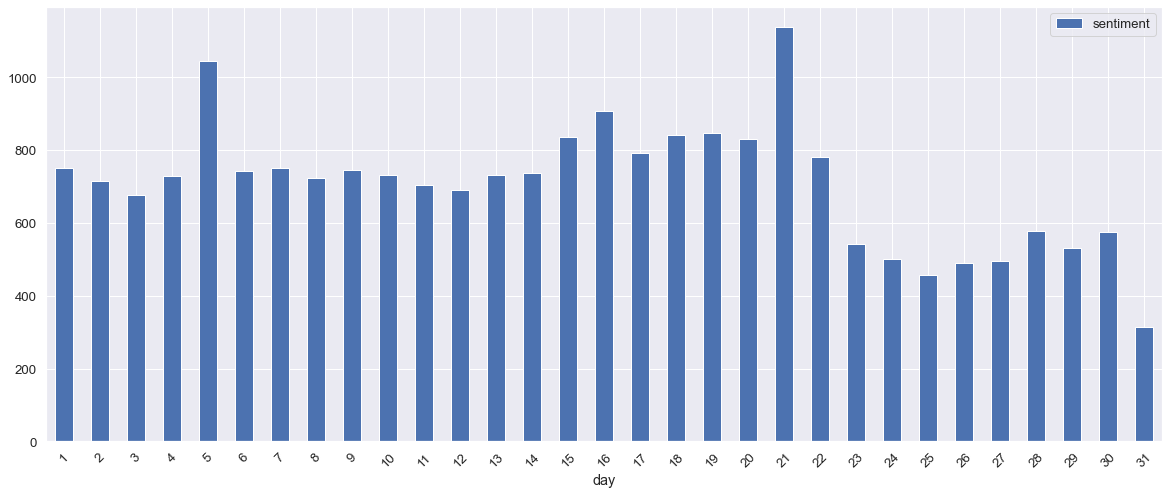

In [28]:
preprocess_review[['day', 'sentiment']].groupby('day').count().plot.bar(figsize=(20,8), rot=45)

In [29]:
preprocess_review['day_of_week'] = preprocess_review.datetime.dt.day_name()
dow_sort = [x.split()[1] for x in preprocess_review.datetime.dt.strftime('%w %A').value_counts().sort_index().index]
dow_sort

['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

<AxesSubplot:xlabel='day_of_week'>

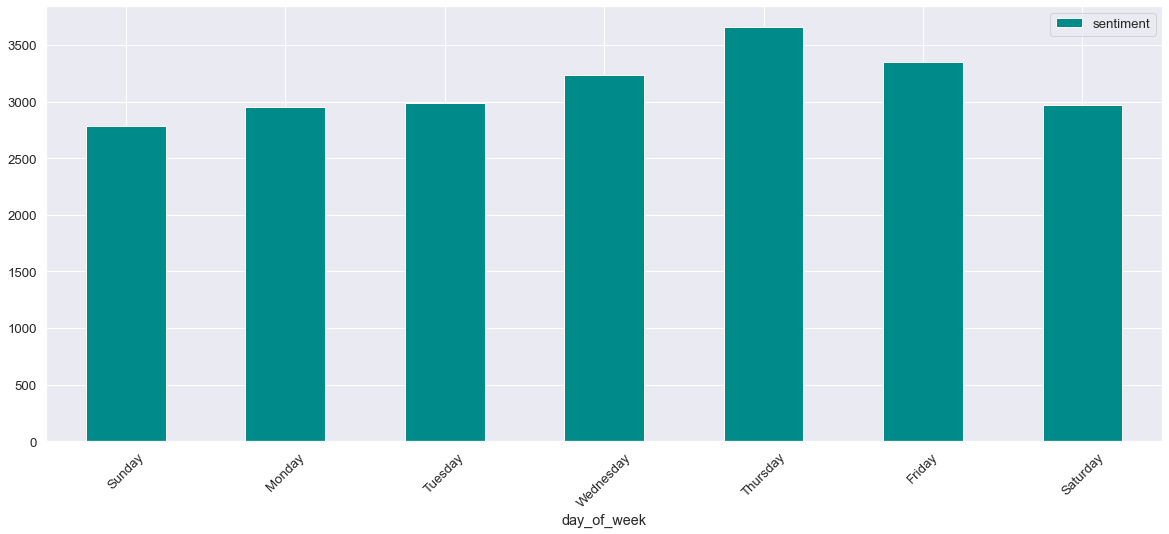

In [30]:
preprocess_review[['day_of_week', 'sentiment']].groupby('day_of_week').count().reindex(dow_sort).plot.bar(figsize=(20,8), rot=45, color = 'darkcyan')

Text Preprocessing
<li>Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model. For NLP, that includes expansion contraction text, text cleaning, stopwords removal, stemming and lemmatization </li>

<li>Text cleaning steps vary according to the type of data and the required task. Generally, the string is converted to lowercase and punctuation is removed before text gets tokenized. Tokenization is the process of splitting a string into a list of strings (or “tokens”). </li>

In [31]:
# remove unnecessary columns
process_reviews=preprocess_review.drop('sortorder', axis=1)
# create a copy 
clean_reviews=process_reviews.copy()

In [32]:
# check the first text
text = clean_reviews.iloc[0, :].reviews
text

'Useless and frustrated app in terms of customers care. My phone was stolen and I try changing my number which the features keep saying "service is on available at the moment try again later" for the past 3 months. I sent an email 3 months ago with no response and I sent another reminder a week ago, still no response. What\'s the features of customers service doing when you knew customers service are not going to solve your problems? I so hate this app for this weird act'

In [33]:
#lets implement the preprocessing utils for the sample_txt
# preprocess text output
from preprocessing_text_utils import remove_emoji
text =  "If there is a space for 0 star, I will.award it. 😢😢My experience has been terrible. They lured me to deposit my money and after 1 transaction I can't make any transition again. All my transactions are not going through. I have sent series of mails and they are not responding."
remove_emoji(text)

"If there is a space for 0 star, I will.award it. My experience has been terrible. They lured me to deposit my money and after 1 transaction I can't make any transition again. All my transactions are not going through. I have sent series of mails and they are not responding."

In [34]:
from preprocessing_text_utils import process_text
process_text(text, do_lemmatization=True)

'space star willaward experience terrible lured deposit money transaction cannot make transition transaction going sent series mail responding'

In [35]:
# create cleaned text columns
clean_reviews['clean_text'] = clean_reviews['reviews'].apply(lambda x: process_text(x, do_lemmatization=True) )
clean_reviews.head()

,reviewid,reviews,score,thumbsupcount,datetime,appid,sentiment,year,month,day,day_of_week,clean_text
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,com.flutterwave.flybarter,Negative,2022,July,21,Thursday,useless frustrated app term customer care phon...
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,com.flutterwave.flybarter,Negative,2022,June,29,Wednesday,scammer lot download app put money downloaded ...
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,com.flutterwave.flybarter,Negative,2022,July,20,Wednesday,experience goodthe app keep logging saying sec...
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,com.flutterwave.flybarter,Negative,2022,June,4,Saturday,annoying app ever signed account created card ...
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,com.flutterwave.flybarter,Negative,2022,June,3,Friday,thought experience would awesome one turned di...


Length Analysis
<p>It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. Unfortunately, this won’t be the case as different sentiments might have similar lengths, but it’s worth a try.</p>

<p>There are several length measures for text data. I will give some examples: </p>

<li>word count: counts the number of tokens in the text (separated by a space) </li>
<li>character count: sum the number of characters of each token</li>
<li>sentence count: count the number of sentences (separated by a period)</li>
<li>average word length: sum of words length divided by the number of words (character count/word count)</li>
<li>average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count) </li>

In [36]:
from preprocessing_text_utils import length_analysis
new_df = clean_reviews.copy()
df = length_analysis(new_df, column = 'reviews')
df.head()

,reviewid,reviews,score,thumbsupcount,datetime,appid,sentiment,year,month,day,day_of_week,clean_text,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,com.flutterwave.flybarter,Negative,2022,July,21,Thursday,useless frustrated app term customer care phon...,88,386,4,4.386364,22.000000
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,com.flutterwave.flybarter,Negative,2022,June,29,Wednesday,scammer lot download app put money downloaded ...,76,353,8,4.644737,9.500000
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,com.flutterwave.flybarter,Negative,2022,July,20,Wednesday,experience goodthe app keep logging saying sec...,88,410,2,4.659091,44.000000
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,com.flutterwave.flybarter,Negative,2022,June,4,Saturday,annoying app ever signed account created card ...,76,331,9,4.355263,8.444444
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,com.flutterwave.flybarter,Negative,2022,June,3,Friday,thought experience would awesome one turned di...,47,213,4,4.531915,11.750000


Visualization of the Length analysis and the sentiments

In [37]:
from visualization_utils import histogram_density_plot


Review word count distribution

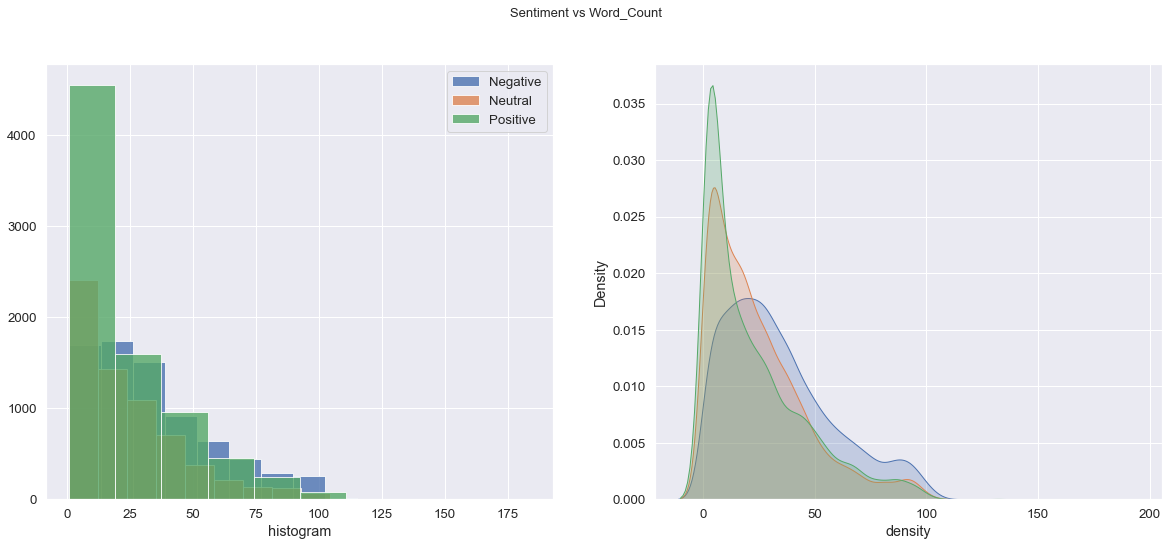

In [38]:
histogram_density_plot(df, 'sentiment', 'word_count')

Review average sentence length distribution

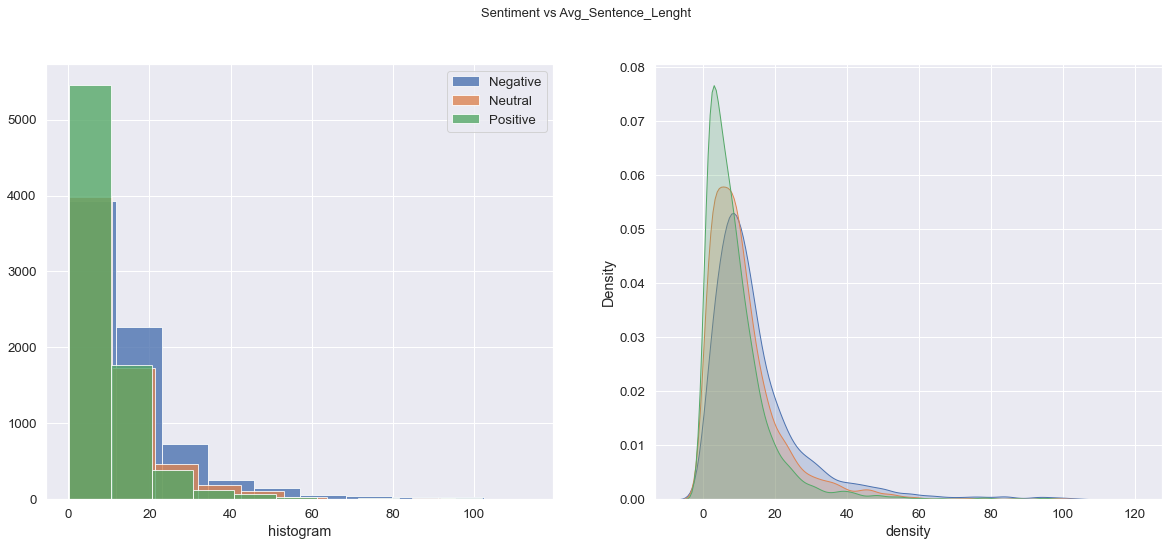

In [39]:
histogram_density_plot(df, 'sentiment', 'avg_sentence_lenght')

Review character length distribution

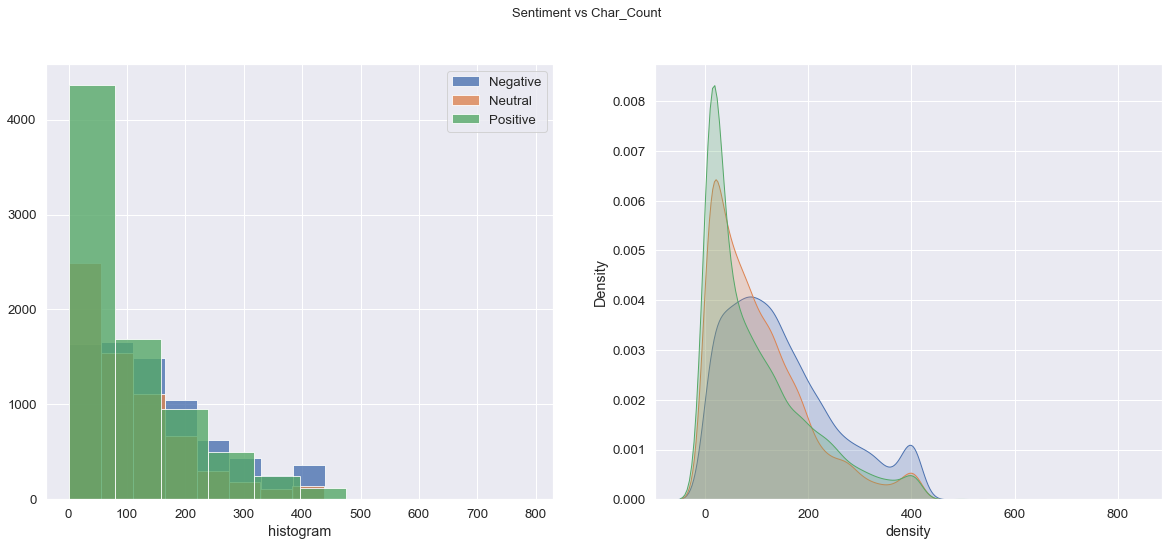

In [40]:
histogram_density_plot(df, 'sentiment', 'char_count')

Lets create more features with TextBlob
<p>Textblob, built on top of NLTK, is one of the most popular, it can assign polarity to words and estimate the sentiment of the whole text as an average. 
It is simple, easy to deploy, will use up fewer resources, gives dependency parsing, and can be used even for small applications.</p>


<p>Textblob can be used for complex analysis and working with textual data. When a sentence is passed into Textblob it gives two outputs, which are polarity and subjectivity. Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment.</p>


In [41]:
df['polarity'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [42]:
name_of_fintech = ['Flutter wave',  'Opay', 'Palm Pay', 'Chipper Cash', 'Interswitch', 'PiggyVest', 'Paga',  'Kuda bank' ]
app_package_id = [
               'com.flutterwave.flybarter',
               'team.opay.pay',
               'com.transsnet.palmpay',
               'com.chippercash',
               'com.quickteller.app',
               'com.piggybankng.piggy',
               'com.mypaga.customer',
               'com.kudabank.app'
]
fin_list = [(app_package_id[i],name_of_fintech[i] ) for i in range(len(app_package_id))]
fin_dict = dict(fin_list)
fin_dict


{'com.flutterwave.flybarter': 'Flutter wave',
 'team.opay.pay': 'Opay',
 'com.transsnet.palmpay': 'Palm Pay',
 'com.chippercash': 'Chipper Cash',
 'com.quickteller.app': 'Interswitch',
 'com.piggybankng.piggy': 'PiggyVest',
 'com.mypaga.customer': 'Paga',
 'com.kudabank.app': 'Kuda bank'}

In [43]:
df['appid'] = df['appid'].map(fin_dict)

In [44]:
# lets print out 5 random reviews with the highest positive sentiment polarity score
pos_pol = df.loc[df.polarity == 1, ['reviews', 'appid']].sample(5).values
for i in pos_pol:
    print(f'{i[0]} - {i[1]}')

Wonderful App - Paga
Wonderful - Paga
Very excellent but resently, access bank users can't receive any money on their account which sent to them from Palm pay. What's happening? - Palm Pay
still the best that I know - Palm Pay
Awesome - Opay


In [45]:
# lets print out 5 random reviews with the most negative sentiment polarity score
pos_pol = df.loc[df.polarity == -1, ['reviews', 'appid']].sample(5).values
for i in pos_pol:
    print(f'{i[0]} ---> {i[1]}')

your customer care for reset of password is extremely terrible and it almost does not work. the feedback rate is close to zero. I still cannot log into my account a d non of my mails have been responsed too. ---> PiggyVest
Please what are you people doing with abeg please!!!! Their app is just terrible, why are you people associating with them???? Please remove abeg from default when transferring money from piggybank ---> PiggyVest
This your upgrade on verify your identity is so boring because it takes time ---> Kuda bank
Getting worst ---> Interswitch
I hate this app!! So stressful and draining! The one star is for the app color. ---> Paga


In [46]:
# lets print out 5 random reviews with the most neutral sentiment polarity score
pos_pol = df.loc[df.polarity == 0, ['reviews', 'appid']].sample(5).values
for i in pos_pol:
    print(f'{i[0]} ---> {i[1]}')

I can't connect my debit card... It keeps loading for hours ---> PiggyVest
Pls uprade this app to the way it is before. ---> Palm Pay
kuda is doing well ---> Kuda bank
I always have issues after deposting money. Always problem with payment reflection. I always need to contact customer care. Which also takes days to respond. I won't advice this app for anybody that needs to do urgent payments. You will always be stressed. At the moment I can't even make an urgent payment. Because of the platform's unreliability. Dollar Deposit rate and withdrawal rate are not the same. You will end up spending a lot using the Credit Card too. ---> Flutter wave
After updating I could not open the app It says I have finished 4/5 tasks but it doesn't load for me to do the last task ---> Kuda bank


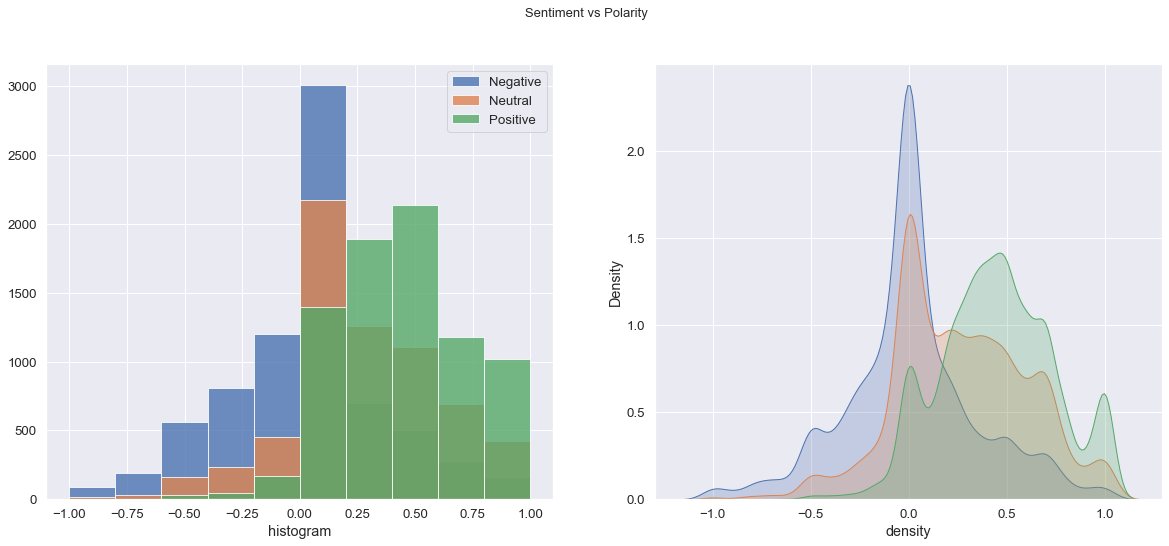

In [47]:
histogram_density_plot(df, 'sentiment', 'polarity')